# Notebook 7
In this notebook our goal To find the best way of clustering the heart disease dataset, finding the best amount of clusters and get the highest silhoutte score using optuna!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster as cluster
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/EmilyBederov/Applied-statistics/main/heart.csv')
data.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [3]:
# preproccesing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# convert categorical features to numerical features 

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert categorical variables to numeric using Label Encoding or One-Hot Encoding
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Use Label Encoding for simplicity
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Display the transformed data
data

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0      172               0      0.0         2             0  
1      156               0      1.0         1             1  
2       98               0      0.0         2             0  
3      108               1      1.5         1             1  
4      122               0      0.0         2             0  
..     ...             ...      ...       ...           ...  
913    132               0      1.2         1             1  
914    141               0      3.4         1             1  
915    115               1      1.2         1             1  
916    174               0      0.0         1             1  
917    173               0      0.0         2             0  

[918 rows x 12 columns]

In [7]:
# Display the mapping for ChestPainType
print("ChestPainType Encoding:")
for i, item in enumerate(label_encoders['ChestPainType'].classes_):
    print(f"{item} -> {i}")

# Display the mapping for RestingECG
print("\nRestingECG Encoding:")
for i, item in enumerate(label_encoders['RestingECG'].classes_):
    print(f"{item} -> {i}")

# Display the mapping for RestingECG
print("\nST_Slope Encoding:")
for i, item in enumerate(label_encoders['ST_Slope'].classes_):
    print(f"{item} -> {i}")

ChestPainType Encoding:
ASY -> 0
ATA -> 1
NAP -> 2
TA -> 3

RestingECG Encoding:
LVH -> 0
Normal -> 1
ST -> 2

ST_Slope Encoding:
Down -> 0
Flat -> 1
Up -> 2


* Sex: Encoded as 0 (Female) and 1 (Male).
* ChestPainType: Different chest pain types are now represented as integers.
* RestingECG: The results of the ECG are encoded.
* ExerciseAngina: Encoded as 0 (No) and 1 (Yes).
* ST_Slope: Encoded into numeric categories.

In [8]:
# Standardize the numeric features
scaler = StandardScaler()
numeric_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'ChestPainType', 'RestingECG', 'ST_Slope']
data_Sc = data.copy()
data_Sc[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data_Sc

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140    1       0.229032   0.410909     0.825070          0   
1   -0.478484    0       1.275059   1.491752    -0.171961          0   
2   -1.751359    1       0.229032  -0.129513     0.770188          0   
3   -0.584556    0      -0.816995   0.302825     0.139040          0   
4    0.051881    1       1.275059   0.951331    -0.034755          0   
..        ...  ...            ...        ...          ...        ...   
913 -0.902775    1       2.321086  -1.210356     0.596393          0   
914  1.536902    1      -0.816995   0.627078    -0.053049          1   
915  0.370100    1      -0.816995  -0.129513    -0.620168          0   
916  0.370100    0       0.229032  -0.129513     0.340275          0   
917 -1.645286    1       1.275059   0.302825    -0.217696          0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0      0.017255  1.382928               0 -0.832432  1.052114             0  
1      0.017255  0.754157               0  0.105664 -0.596078             1  
2      1.601219 -1.525138               0 -0.832432  1.052114             0  
3      0.017255 -1.132156               1  0.574711 -0.596078             1  
4      0.017255 -0.581981               0 -0.832432  1.052114             0  
..          ...       ...             ...       ...       ...           ...  
913    0.017255 -0.188999               0  0.293283 -0.596078             1  
914    0.017255  0.164684               0  2.357094 -0.596078             1  
915    0.017255 -0.857069               1  0.293283 -0.596078             1  
916   -1.566710  1.461525               0 -0.832432 -0.596078             1  
917    0.017255  1.422226               0 -0.832432  1.052114             0  

[918 rows x 12 columns]

Firsly, we will use K-Means to cluster the data, then we will use the silhouette score plot to evaluate how well the k-means algorithm has clustered the data

In [9]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 5

# Apply k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_Sc['Cluster'] = kmeans.fit_predict(data_Sc[numeric_columns + categorical_columns])

In [10]:
from sklearn.decomposition import PCA

# Assuming `scaled_features` contains your scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_Sc)

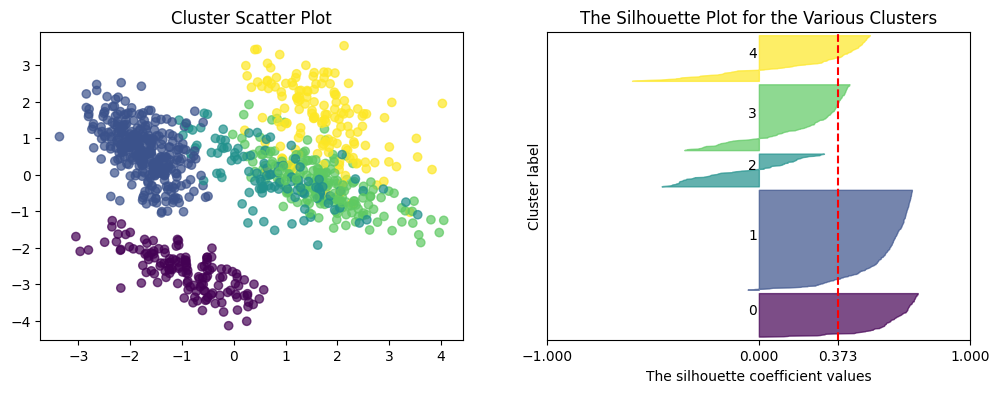

In [11]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# Function to plot silhouette analysis
def plot_silhouette(X, labels):
    plt.figure(figsize=(12, 4))
    
    # Scatter plot for clusters
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.title("Cluster Scatter Plot")
    
    # Silhouette plot
    plt.subplot(1, 2, 2)
    viridis = plt.get_cmap('viridis')
    silhouettes = silhouette_samples(X, labels)
    y_lower = 10
    clusters = np.unique(labels)
    
    for idx, label in enumerate(clusters):
        ith_cluster_silhouette_values = silhouettes[labels == label]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = viridis(float(idx) / (clusters.size - 1))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'{label}')
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The Silhouette Plot for the Various Clusters")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    
    sil_score = silhouettes.mean()
    plt.axvline(x=sil_score, color="red", linestyle="--")

    plt.yticks([])
    plt.xticks([-1, 0, 1, sil_score])
    plt.xlim([-1, 1])
    plt.ylim([0, len(X) + (clusters.size + 1) * 10])
    plt.show()


# Plot the silhouette plot
plot_silhouette(X_pca, data_Sc['Cluster'].values)

### Dimensionality Reduction:
PCA (Principal Component Analysis) is used to reduce the dimensionality of the dataset. The original dataset is n-dimensional (where n is the number of features), making it difficult to visualize and understand the clustering in such a high-dimensional space.
- our data is 12 dimensonal data, it might be incredibly beneficial to reduce the number of dimensions while preserving as much information about your data as possible.
### visualizing Clusters in 2D: 
By applying PCA, the data is projected into a 2D space, capturing the most significant variance in the data. This allows for an easier and more interpretable visualization of the clusters.
### Maintaining Variance:
PCA ensures that the 2D representation retains as much of the original data’s variability as possible. This means that the clusters you see in the 2D scatter plot are representative of the actual structure in the higher-dimensional space.

### Explanation of the Plots

1. Cluster Scatter Plot:
    * Purpose: This plot is used to visualize how the data points are distributed in the reduced 2D space created by PCA.
    * Axes: The axes represent the first two principal components, which are linear combinations of the original features.
    * Color Coding: Each color represents a different cluster. Points that are close together and share the same color are considered part of the same cluster.
2. Silhouette Plot:
    * Purpose: This plot measures how similar each point is to its own cluster compared to other clusters.
    * Silhouette Coefficient: The silhouette coefficient ranges from -1 to 1, where:
    * A value close to 1 indicates that the point is well-matched to its own cluster and poorly matched to neighboring clusters.
    * A value close to 0 indicates that the point is on or very close to the decision boundary between two clusters.
    * A negative value indicates that the point might have been assigned to the wrong cluster.
    * Visualization: The width of each cluster’s silhouette plot reflects the number of points in that cluster. The red dashed line represents the average silhouette score across all clusters.


### parallel coordinate plot
We also use a parallel coordinate plot to visualize all features simultaneously. Unlike the PCA plot, which reduces the data to two dimensions, the parallel coordinate plot allows us to see how each feature contributes to the clustering. This can be particularly useful when we want to understand the relationship between all features.”

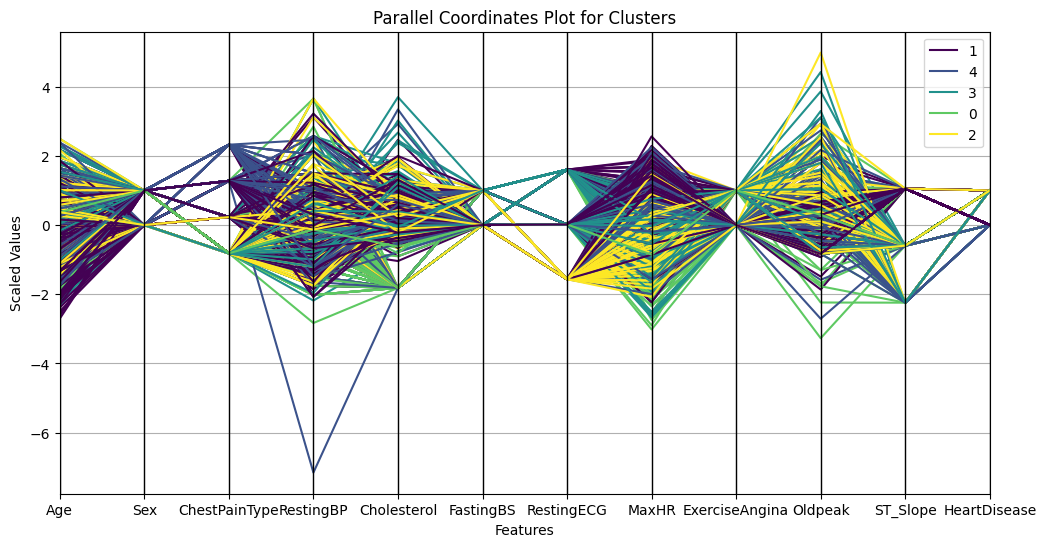

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

data_Sc['Cluster'] = data_Sc['Cluster'].astype(str)

plt.figure(figsize=(12, 6))
parallel_coordinates(data_Sc, 'Cluster', colormap='viridis')
plt.title("Parallel Coordinates Plot for Clusters")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.show()

### Silhouette Score Consistency:
* Explanation: “It’s important to note that the silhouette score, which measures the quality of the clustering, does not change whether we use PCA or a parallel coordinate plot. The silhouette score is calculated based on the original high-dimensional data, so it remains consistent across different visualizations.”

now, we will apply permutation

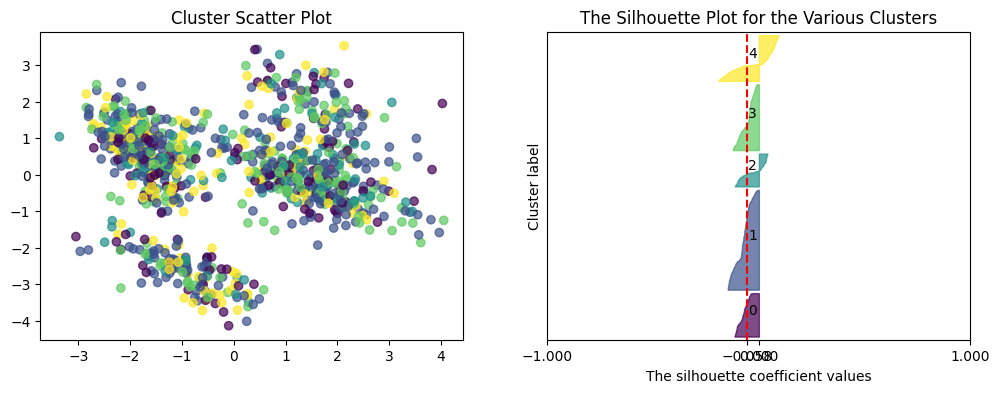

In [13]:
data_Sc['Cluster'] = data_Sc['Cluster'].astype(int)
permuted_labels = np.random.permutation(data_Sc['Cluster'].values)
permuted_labels = permuted_labels.astype(int)
plot_silhouette(X_pca, permuted_labels)

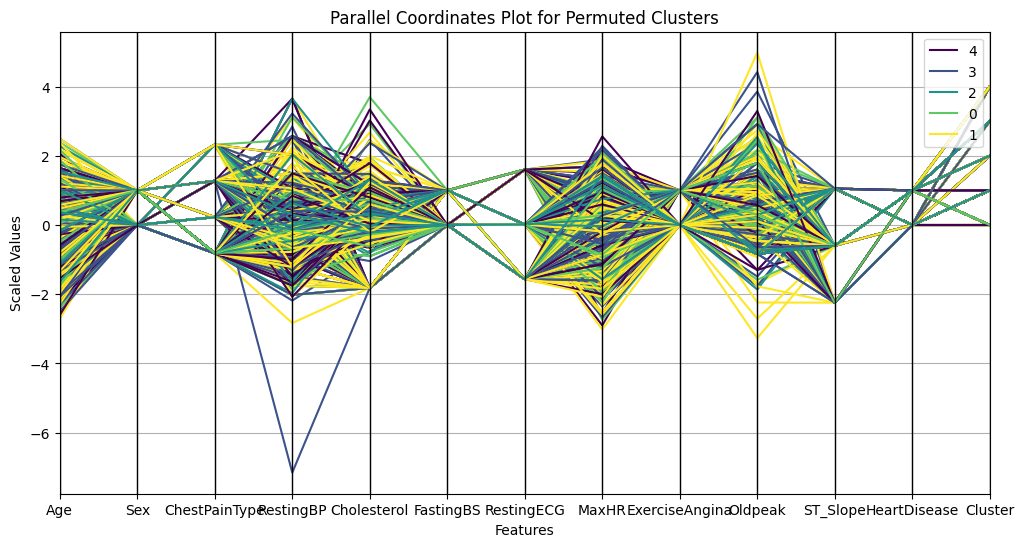

In [14]:
data_Sc['PermutedCluster'] = permuted_labels.astype(str)

# Step 3: Create Parallel Coordinates Plot for permuted clusters
plt.figure(figsize=(12, 6))
parallel_coordinates(data_Sc, 'PermutedCluster', colormap='viridis')
plt.title("Parallel Coordinates Plot for Permuted Clusters")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.show()

### RESULT:
This parallel coordinates plot will display how the features relate to the permuted clusters. It should look more chaotic than the plot with the actual clusters, reflecting the random nature of the label assignments.

# DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2, min_samples=10).fit(data_Sc)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 422


Unique labels identified by DBSCAN: [-1  0  1  2  3  4  5]


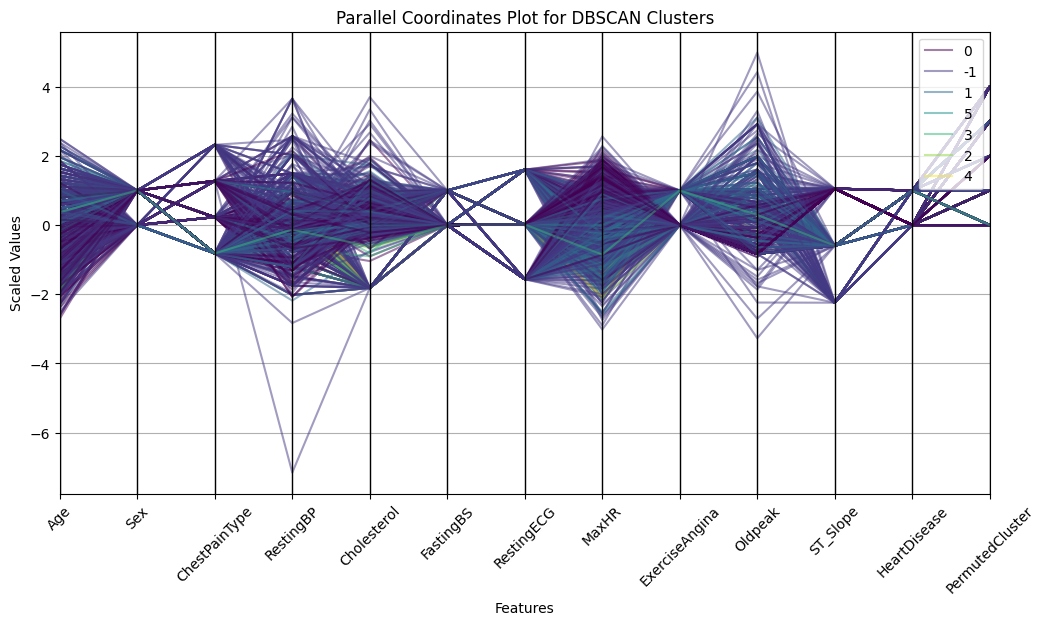

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import parallel_coordinates

# Check the labels directly after DBSCAN
print("Unique labels identified by DBSCAN:", np.unique(labels))

# Plot the parallel coordinates plot using the same labels
plt.figure(figsize=(12, 6))
data_Sc['Cluster'] = labels  # Ensure you are using DBSCAN labels
parallel_coordinates(data_Sc, 'Cluster', colormap='viridis', alpha=0.5)
plt.title("Parallel Coordinates Plot for DBSCAN Clusters")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.xticks(rotation=45)
plt.show()

Silhouette Score for DBSCAN: 0.08116664126240491


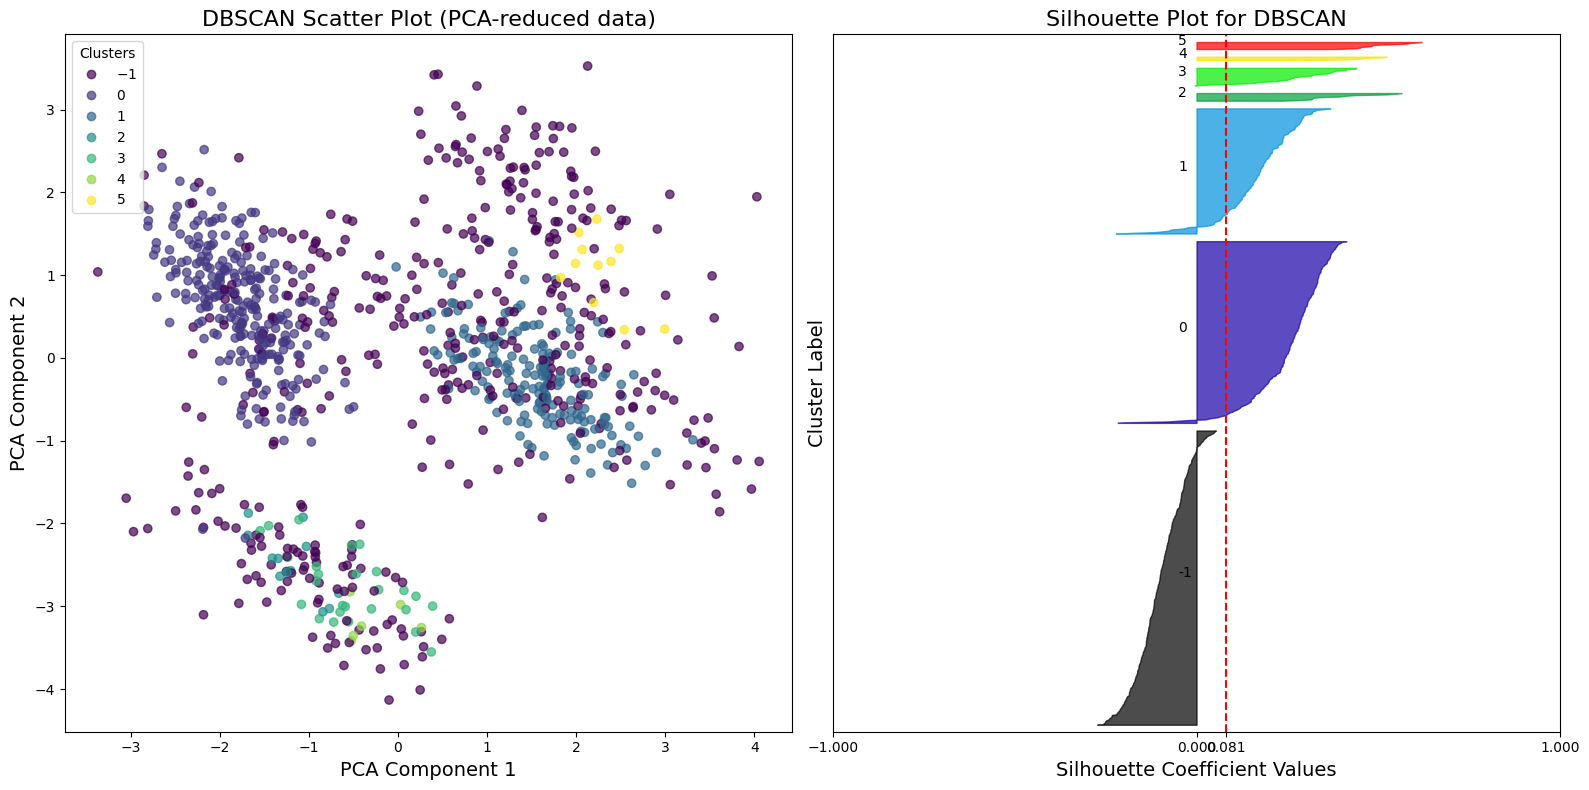

In [17]:
 

# Step 2: Calculate the silhouette score
sil_score = silhouette_score(data_Sc, labels)
print(f"Silhouette Score for DBSCAN: {sil_score}")

# Step 3: Create the Silhouette Plot and Scatter Plot side by side
def plot_silhouette_and_scatter(X, labels):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot
    scatter = axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    axs[0].set_title("DBSCAN Scatter Plot (PCA-reduced data)", fontsize=16)
    axs[0].set_xlabel("PCA Component 1", fontsize=14)
    axs[0].set_ylabel("PCA Component 2", fontsize=14)
    axs[0].legend(*scatter.legend_elements(), title="Clusters")

    # Silhouette plot
    silhouettes = silhouette_samples(data_Sc, labels)
    y_lower = 10
    clusters = np.unique(labels)

    for idx, label in enumerate(clusters):
        ith_cluster_silhouette_values = silhouettes[labels == label]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(idx) / clusters.size)
        axs[1].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
        axs[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
        y_lower = y_upper + 10

    axs[1].axvline(x=sil_score, color="red", linestyle="--")
    axs[1].set_title("Silhouette Plot for DBSCAN", fontsize=16)
    axs[1].set_xlabel("Silhouette Coefficient Values", fontsize=14)
    axs[1].set_ylabel("Cluster Label", fontsize=14)
    axs[1].set_yticks([])
    axs[1].set_xticks([-1, 0, 1, sil_score])
    axs[1].set_xlim([-1, 1])
    axs[1].set_ylim([0, len(data_Sc) + (clusters.size + 1) * 10])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the silhouette and scatter plots
plot_silhouette_and_scatter(X_pca, labels)

AS WE LEARNED IN CLASS:
* The silhouette doesn't work well with noise class: -1.
* -1 is not a "real" cluster, but it treats it like one.

In [18]:
filtered_data = data_Sc[labels != -1]  # This should be your original scaled data without noise
filtered_labels = labels[labels != -1]
# Calculate silhouette score without noise
sil_score = silhouette_score(filtered_data, filtered_labels)
print(f"Silhouette Score for DBSCAN (without noise): {sil_score}")

Silhouette Score for DBSCAN (without noise): 0.2366569105467386


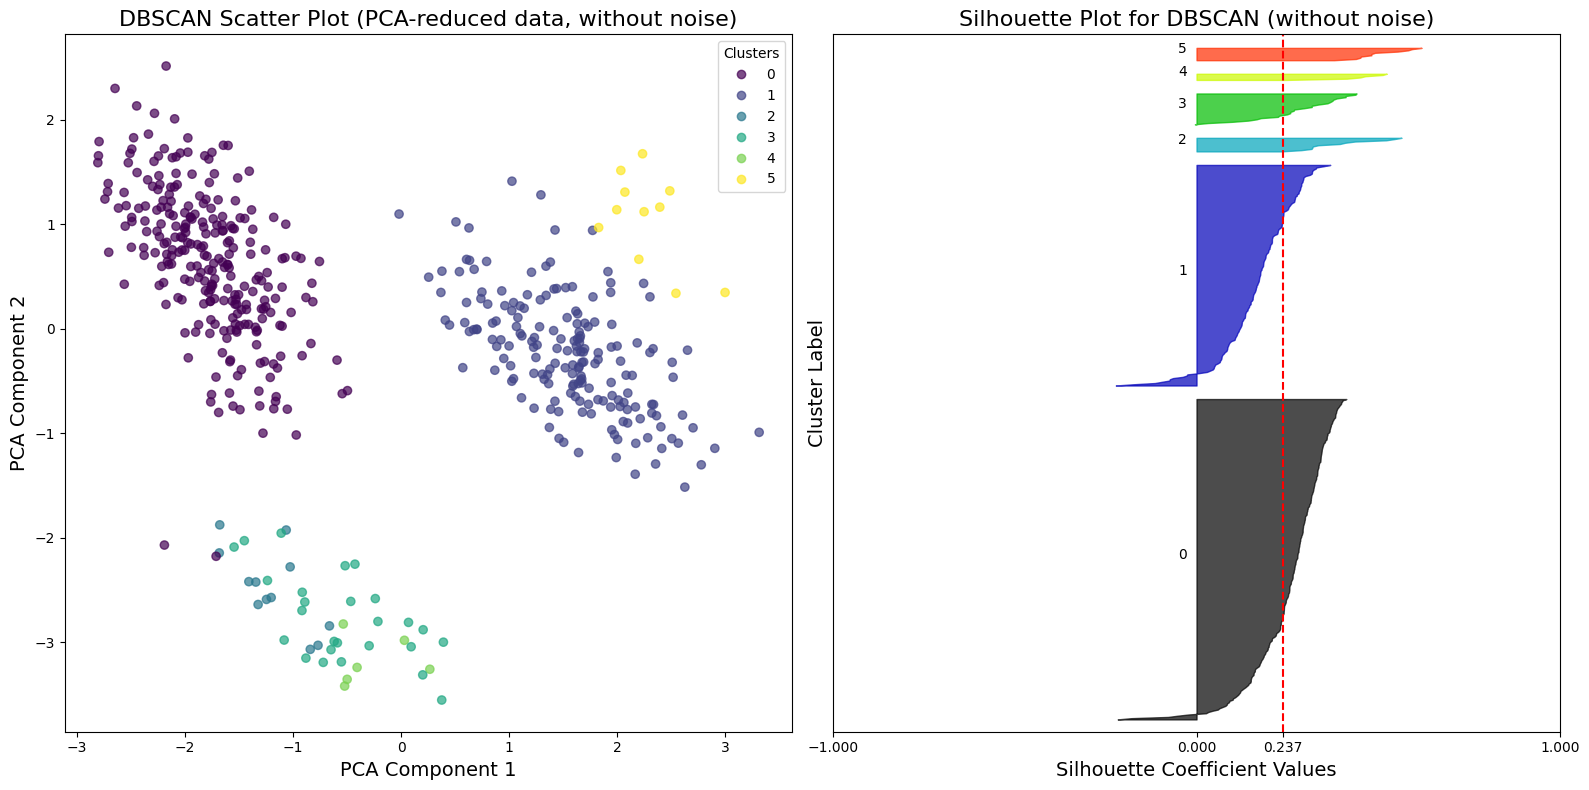

In [19]:
# Plot the scatter plot and silhouette plot without noise, but using the original PCA components
def plot_silhouette_and_scatter_without_noise(X, labels, filtered_data, filtered_labels, sil_score):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot without noise points, but using the original PCA components
    scatter = axs[0].scatter(X[labels != -1, 0], X[labels != -1, 1], c=filtered_labels, cmap='viridis', alpha=0.7)
    axs[0].set_title("DBSCAN Scatter Plot (PCA-reduced data, without noise)", fontsize=16)
    axs[0].set_xlabel("PCA Component 1", fontsize=14)
    axs[0].set_ylabel("PCA Component 2", fontsize=14)
    axs[0].legend(*scatter.legend_elements(), title="Clusters")

    # Silhouette plot
    silhouettes = silhouette_samples(filtered_data, filtered_labels)
    y_lower = 10
    clusters = np.unique(filtered_labels)

    for idx, label in enumerate(clusters):
        ith_cluster_silhouette_values = silhouettes[filtered_labels == label]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(idx) / clusters.size)
        axs[1].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
        axs[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
        y_lower = y_upper + 10

    axs[1].axvline(x=sil_score, color="red", linestyle="--")
    axs[1].set_title("Silhouette Plot for DBSCAN (without noise)", fontsize=16)
    axs[1].set_xlabel("Silhouette Coefficient Values", fontsize=14)
    axs[1].set_ylabel("Cluster Label", fontsize=14)
    axs[1].set_yticks([])
    axs[1].set_xticks([-1, 0, 1, sil_score])
    axs[1].set_xlim([-1, 1])
    axs[1].set_ylim([0, len(filtered_data) + (clusters.size + 1) * 10])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the silhouette and scatter plots without noise
plot_silhouette_and_scatter_without_noise(X_pca, labels, filtered_data, filtered_labels, sil_score)

We can see the 'REAL' clusters, and the huge upgrade in the silohout Coefficient Value!

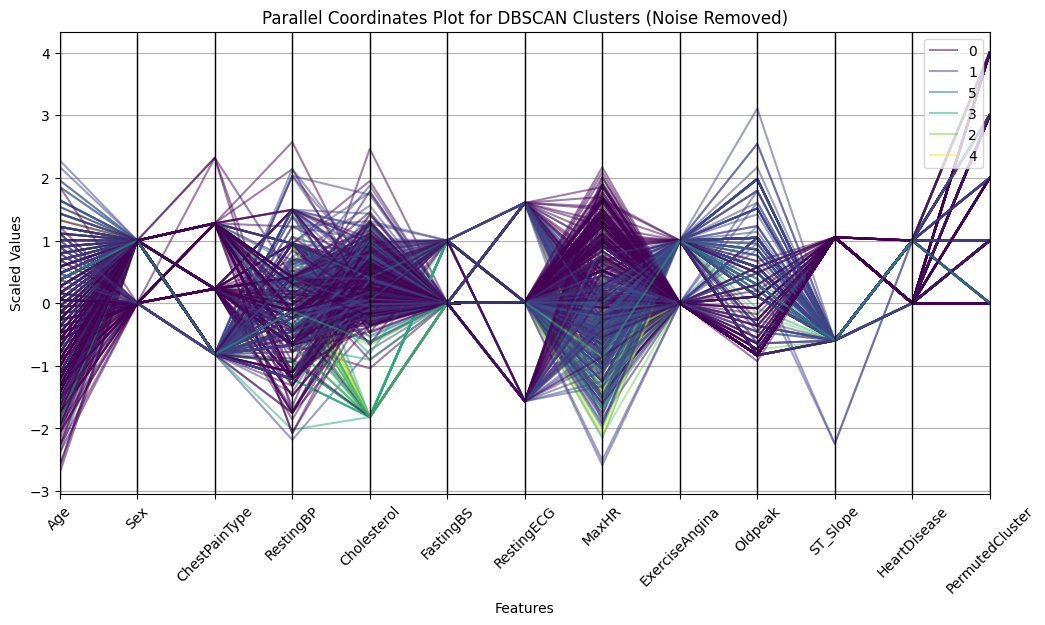

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import parallel_coordinates

# Remove noise points from the dataset (i.e., where Cluster == -1)
filtered_data = data_Sc[data_Sc['Cluster'] != -1]

# Plot the parallel coordinates plot without the noise points
plt.figure(figsize=(12, 6))
parallel_coordinates(filtered_data, 'Cluster', colormap='viridis', alpha=0.5)
plt.title("Parallel Coordinates Plot for DBSCAN Clusters (Noise Removed)")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.xticks(rotation=45)
plt.show()

# Hyperparameter Optimization

In [21]:
import optuna

In [22]:
# Define the objective function using PCA-reduced data
def objective(trial):
    eps = trial.suggest_float("eps", 0.01, 2.0)
    min_samples = trial.suggest_int("min_samples", 2, 15)
    
    # Apply DBSCAN on the PCA-reduced data
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_pca)
    
    # Try to calculate the silhouette score
    try:
        score = silhouette_score(X_pca, db.labels_)
    except ValueError:  # If n_clusters == 1, silhouette_score will raise a ValueError
        score = -1.1  # Assign a poor score for this configuration
    
    return score

In [23]:
# Create the study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-08-28 21:59:54,558] A new study created in memory with name: no-name-f52babea-c0b1-4ab4-b4df-2aa343aeaf52
[I 2024-08-28 21:59:54,579] Trial 0 finished with value: 0.3366126804078312 and parameters: {'eps': 0.8198846326851995, 'min_samples': 15}. Best is trial 0 with value: 0.3366126804078312.
[I 2024-08-28 21:59:54,590] Trial 1 finished with value: -1.1 and parameters: {'eps': 1.4327625057564801, 'min_samples': 12}. Best is trial 0 with value: 0.3366126804078312.
[I 2024-08-28 21:59:54,611] Trial 2 finished with value: -0.16752451003245794 and parameters: {'eps': 0.17986122051066486, 'min_samples': 15}. Best is trial 0 with value: 0.3366126804078312.
[I 2024-08-28 21:59:54,636] Trial 3 finished with value: 0.3183541834815469 and parameters: {'eps': 0.642224608588978, 'min_samples': 13}. Best is trial 0 with value: 0.3366126804078312.
[I 2024-08-28 21:59:54,647] Trial 4 finished with value: -1.1 and parameters: {'eps': 1.5427467319877706, 'min_samples': 2}. Best is trial 0 with 

In [24]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.336613 2024-08-28 21:59:54.559279 2024-08-28 21:59:54.579194   
1        1 -1.100000 2024-08-28 21:59:54.585072 2024-08-28 21:59:54.590888   
2        2 -0.167525 2024-08-28 21:59:54.594842 2024-08-28 21:59:54.611118   
3        3  0.318354 2024-08-28 21:59:54.616362 2024-08-28 21:59:54.633861   
4        4 -1.100000 2024-08-28 21:59:54.638600 2024-08-28 21:59:54.647291   
..     ...       ...                        ...                        ...   
95      95  0.336613 2024-08-28 21:59:57.870275 2024-08-28 21:59:57.901313   
96      96  0.333779 2024-08-28 21:59:57.915018 2024-08-28 21:59:57.952823   
97      97  0.336613 2024-08-28 21:59:57.954804 2024-08-28 21:59:58.004299   
98      98  0.192185 2024-08-28 21:59:58.022800 2024-08-28 21:59:58.057355   
99      99  0.339027 2024-08-28 21:59:58.058952 2024-08-28 21:59:58.102109   

                 duration  params_eps  params_min_samples     state  
0  0 days 00:00:00.019915    0.819885                  15  COMPLETE  
1  0 days 00:00:00.005816    1.432763                  12  COMPLETE  
2  0 days 00:00:00.016276    0.179861                  15  COMPLETE  
3  0 days 00:00:00.017499    0.642225                  13  COMPLETE  
4  0 days 00:00:00.008691    1.542747                   2  COMPLETE  
..                    ...         ...                 ...       ...  
95 0 days 00:00:00.031038    0.935631                   7  COMPLETE  
96 0 days 00:00:00.037805    0.515299                   3  COMPLETE  
97 0 days 00:00:00.049495    0.795948                   5  COMPLETE  
98 0 days 00:00:00.034555    0.443564                   2  COMPLETE  
99 0 days 00:00:00.043157    0.567754                   4  COMPLETE  

[100 rows x 8 columns]

In [25]:
study.best_trials

[FrozenTrial(number=77, state=1, values=[0.42212691163680166], datetime_start=datetime.datetime(2024, 8, 28, 21, 59, 57, 195298), datetime_complete=datetime.datetime(2024, 8, 28, 21, 59, 57, 217619), params={'eps': 0.3026844312369493, 'min_samples': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'eps': FloatDistribution(high=2.0, log=False, low=0.01, step=None), 'min_samples': IntDistribution(high=15, log=False, low=2, step=1)}, trial_id=77, value=None)]

In [26]:

# After optimization, you can access the best parameters and apply them to DBSCAN
best_eps = study.best_trial.params['eps']
best_min_samples = study.best_trial.params['min_samples']

# Apply DBSCAN with the best parameters
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(data_Sc)
labels_best = dbscan_best.labels_

# Add the cluster labels to your scaled data for further analysis
data_Sc['Cluster'] = labels_best

# Print the best parameters
print(f"Best parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Silhouette Score for the best trial: {study.best_trial.value}")

Best parameters: eps=0.3026844312369493, min_samples=5
Silhouette Score for the best trial: 0.42212691163680166


In [27]:
# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [28]:
plot_optimization_history(study)

Visualizes the progression of the objective value = the silhouette score over the course of the optimization trials. 
Each dot represents a single trial, and the objective value for that trial is plotted on the y-axis.
* The Objective Value is the silhouette score that was achieved for a given set of parameters in that trial.
* The Best Value line represents the best silhouette score obtained up to that point in the optimization process.

In [29]:
plot_parallel_coordinate(study)

Visualizes the relationship between the parameters (eps, min_samples) and the corresponding objective value (silhouette score).
* Each line represents a single trial, with the line crossing different axes at the values that were used for that trial.
* The Objective Value axis is on the left, while eps and min_samples are the two hyperparameters shown on the right.
* We can identify which parameters have a strong influence on the objective value. If lines converge or diverge significantly at particular parameter values, it suggests that those parameters are crucial for the performance of the DBSCAN algorithm.

In [30]:
plot_contour(study)

Visualizes the relationship between two hyperparameters (eps and min_samples) and their corresponding objective value (silhouette score).
* The plot is a 2D heatmap where:
* The x-axis represents the eps parameter.
* The y-axis represents the min_samples parameter.
* The color gradient (from dark blue to light blue/white) represents the objective value, with darker colors indicating higher silhouette scores.

In [31]:
plot_slice(study)

Visualizes the effect of each hyperparameter on the objective value (silhouette score) independently. It is composed of two subplots:
* The left subplot shows how the objective value changes with different values of eps.
* The right subplot shows how the objective value changes with different values of min_samples.
* Each dot in the plot represents a single trial, with the color intensity indicating how recent the trial was (darker dots correspond to more recent trials).


In [32]:
plot_param_importances(study)

#### Importance of eps:
The plot shows that eps (epsilon) has an importance value of 1.00, meaning it is the most influential hyperparameter in determining the clustering quality (as measured by the silhouette score).
* This indicates that the choice of eps has a significant impact on how well DBSCAN performs. Small changes in eps can lead to substantial differences in the clustering results.
#### Importance of min_samples:
* The min_samples parameter has an importance of less than 0.01, meaning it has very little influence on the silhouette score compared to eps.
* This suggests that varying min_samples within the tested range does not significantly affect the clustering outcome in this particular dataset.

# Apply DBSCAN with the best parameters on the PCA-reduced data

Silhouette Score for optimized DBSCAN: 0.42212691163680166


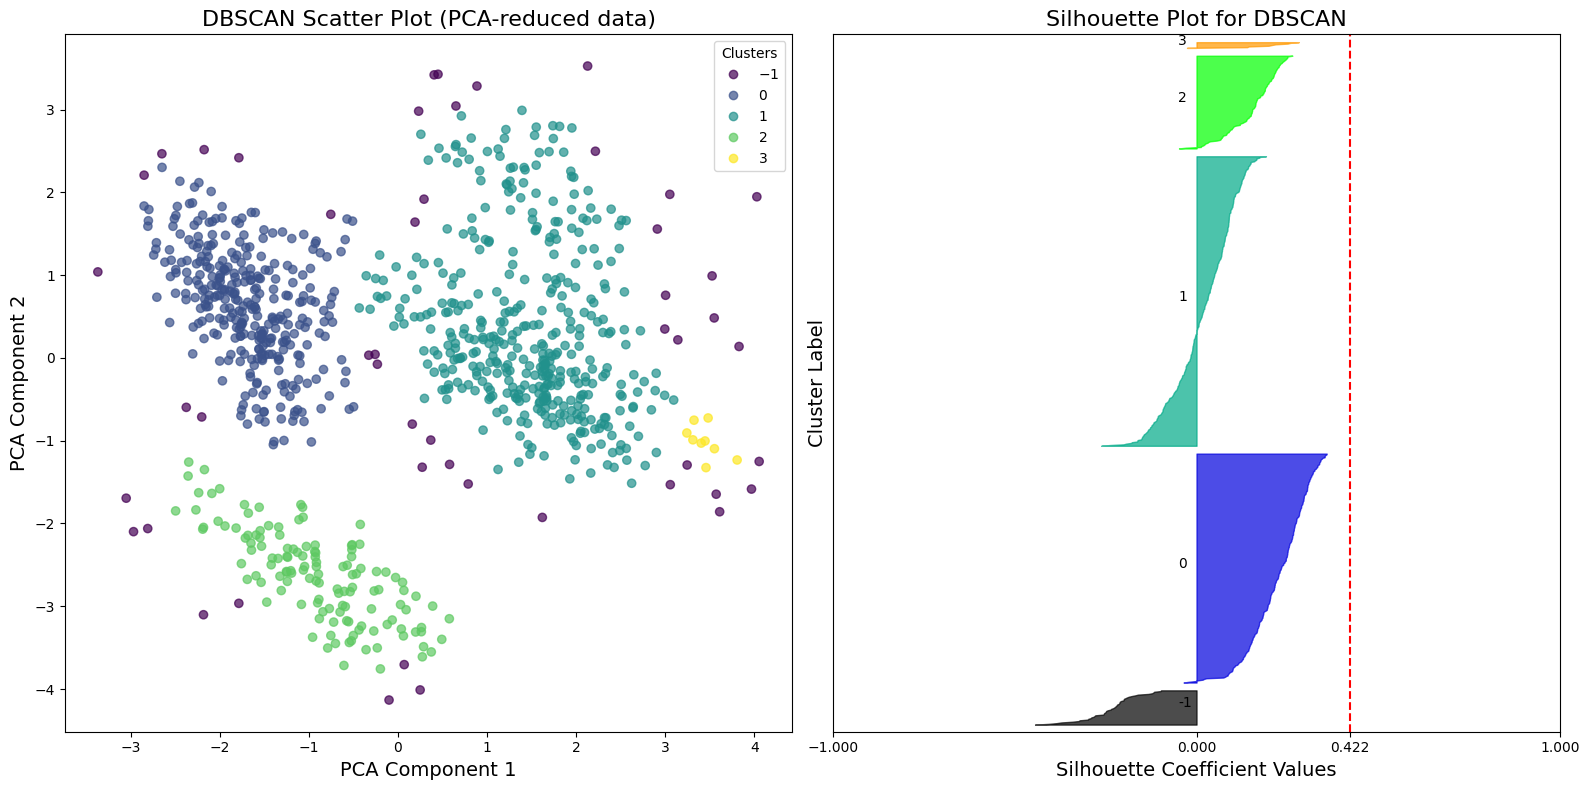

In [33]:
db_optimized = DBSCAN(eps=study.best_params['eps'], min_samples=study.best_params['min_samples']).fit(X_pca)

# Calculate silhouette score with the best parameters
sil_score = silhouette_score(X_pca, db_optimized.labels_)
print(f"Silhouette Score for optimized DBSCAN: {sil_score}")

# Plot the results
plot_silhouette_and_scatter(X_pca, db_optimized.labels_)

# Apply DBSCAN with the best parameters on the PCA-reduced data without Noise

Silhouette Score for optimized DBSCAN (without noise): 0.475715211513563


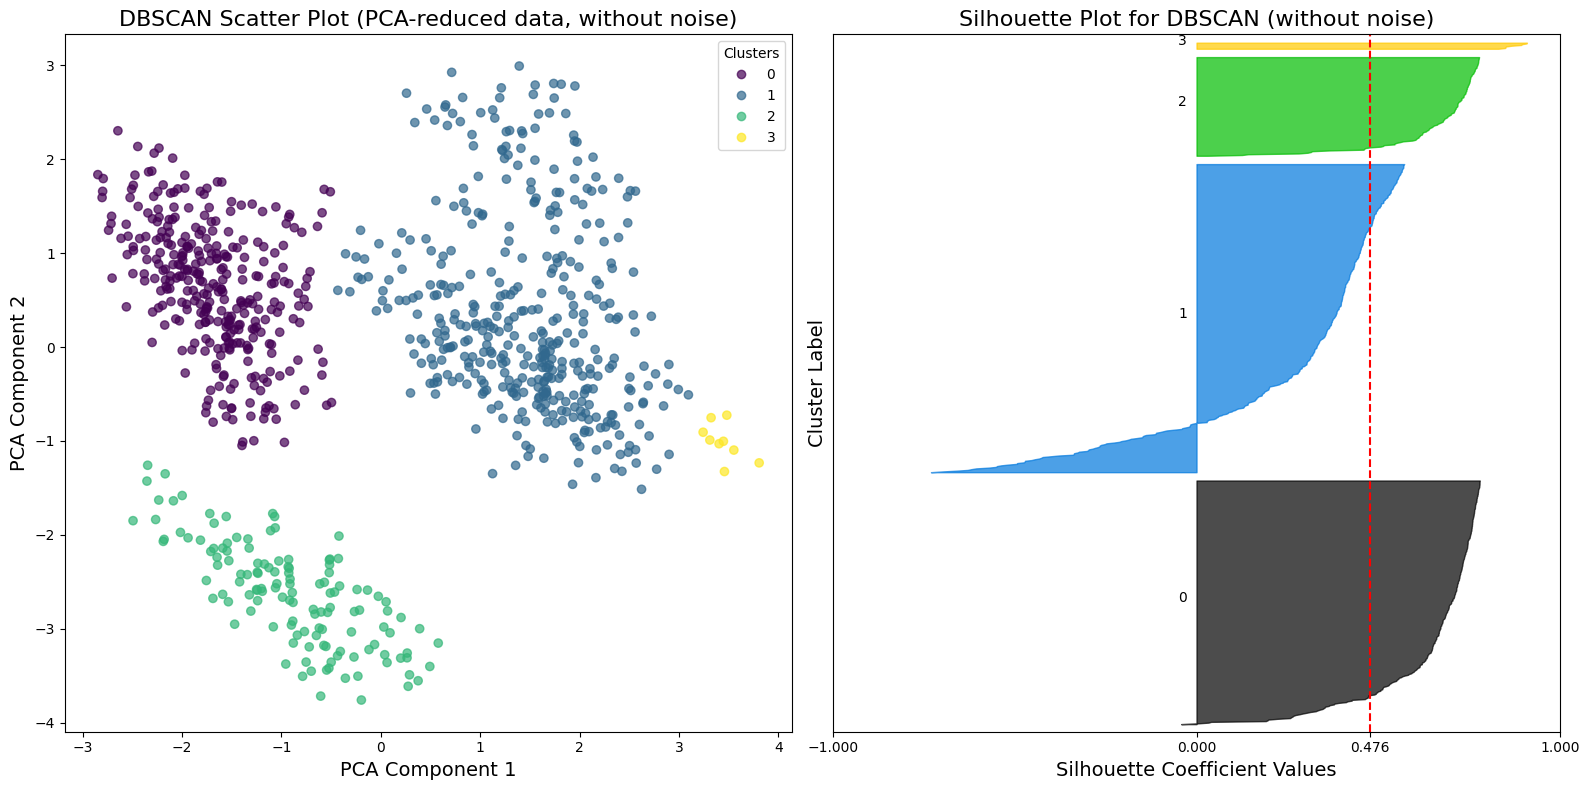

In [34]:
db_optimized = DBSCAN(eps=study.best_params['eps'], min_samples=study.best_params['min_samples']).fit(X_pca)

# Filter out the noise points
filtered_X_pca = X_pca[db_optimized.labels_ != -1]
filtered_labels = db_optimized.labels_[db_optimized.labels_ != -1]

# Calculate silhouette score without noise
sil_score = silhouette_score(filtered_X_pca, filtered_labels)
print(f"Silhouette Score for optimized DBSCAN (without noise): {sil_score}")

# Plot the results without noise
def plot_silhouette_and_scatter_without_noise(X, labels, sil_score):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot without noise points
    scatter = axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    axs[0].set_title("DBSCAN Scatter Plot (PCA-reduced data, without noise)", fontsize=16)
    axs[0].set_xlabel("PCA Component 1", fontsize=14)
    axs[0].set_ylabel("PCA Component 2", fontsize=14)
    axs[0].legend(*scatter.legend_elements(), title="Clusters")

    # Silhouette plot
    silhouettes = silhouette_samples(X, labels)
    y_lower = 10
    clusters = np.unique(labels)

    for idx, label in enumerate(clusters):
        ith_cluster_silhouette_values = silhouettes[labels == label]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(idx) / clusters.size)
        axs[1].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
        axs[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
        y_lower = y_upper + 10

    axs[1].axvline(x=sil_score, color="red", linestyle="--")
    axs[1].set_title("Silhouette Plot for DBSCAN (without noise)", fontsize=16)
    axs[1].set_xlabel("Silhouette Coefficient Values", fontsize=14)
    axs[1].set_ylabel("Cluster Label", fontsize=14)
    axs[1].set_yticks([])
    axs[1].set_xticks([-1, 0, 1, sil_score])
    axs[1].set_xlim([-1, 1])
    axs[1].set_ylim([0, len(X) + (clusters.size + 1) * 10])
    
    plt.tight_layout()
    plt.show()

# Plot the silhouette and scatter plots without noise
plot_silhouette_and_scatter_without_noise(filtered_X_pca, filtered_labels, sil_score)

We can see 4 clusters, we see the great improvement in the silhoette score, as needed.